In [159]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и знакомство с данными

Для работы вам понадобятся предобработанные данные датасета для «Прогноза популярности статьи на Хабре».

In [160]:
# https://raw.githubusercontent.com/miptgirl/habra_materials/master/prophet/howpop_train.csv
df = pd.read_csv('howpop_train.csv')

In [3]:
df.shape

(134137, 17)

In [161]:
df.head(3).T

0  \
url                             https://habrahabr.ru/post/18284/   
domain                                              habrahabr.ru   
post_id                                                    18284   
published                                    2008-01-01 18:19:00   
author                                                    @Tapac   
flow                                                     develop   
polling                                                    False   
content_len                                                 4305   
title             Новогодний подарок блоггерам — WordPress 2.3.2   
comments                                                       0   
favs                                                           0   
views                                                        236   
votes_plus                                                     0   
votes_minus                                                    0   
views_lognorm                                          -0.792687   
favs_lognorm                                            -1.34407   
comments_lognorm                                        -2.43687   

                                                                  1  \
url                                https://habrahabr.ru/post/18285/   
domain                                                 habrahabr.ru   
post_id                                                       18285   
published                                       2008-01-01 18:30:00   
author                                                   @DezmASter   
flow                                                         design   
polling                                                       False   
content_len                                                    7344   
title             Сумасшедшие яйца, или сервис для отслеживания ...   
comments                                                          1   
favs                                                              1   
views                                                           353   
votes_plus                                                        1   
votes_minus                                                       0   
views_lognorm                                             -0.485214   
favs_lognorm                                              -0.831946   
comments_lognorm                                           -1.87319   

                                                                  2  
url                                https://habrahabr.ru/post/18286/  
domain                                                 habrahabr.ru  
post_id                                                       18286  
published                                       2008-01-01 18:34:00  
author                                                   @DezmASter  
flow                                                         design  
polling                                                       False  
content_len                                                    8431  
title             Сумасшедшие яйца, или сервис для отслеживания ...  
comments                                                         47  
favs                                                             72  
views                                                          1200  
votes_plus                                                       45  
votes_minus                                                       5  
views_lognorm                                               0.44609  
favs_lognorm                                                1.79402  
comments_lognorm                                           0.574656

Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm`. Выберем их с помощью `filter()` и удалим drop-ом:

In [162]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [163]:
df.describe().T

count           mean           std      min       25%  \
post_id      134137.0  181307.054265  81766.350702  18284.0  115565.0   
content_len  134137.0    7516.929699   8724.771640      1.0    2179.0   
comments     134137.0      39.625994     62.398958      0.0       7.0   
favs         134137.0      71.999866    145.854135      0.0       8.0   
views        134137.0   16631.013084  31479.819691      3.0    2100.0   
votes_plus   133566.0      35.536888     42.461073      0.0      11.0   
votes_minus  133566.0       8.050035     11.398282      0.0       2.0   

                  50%       75%        max  
post_id      182666.0  257401.0   314088.0  
content_len    4949.0    9858.0   352471.0  
comments         19.0      48.0     2266.0  
favs             27.0      78.0     8718.0  
views          7600.0   18700.0  1730000.0  
votes_plus       22.0      45.0     1466.0  
votes_minus       5.0      10.0      445.0

In [164]:
df.describe(include = ['object', 'bool']).T # бинарные и категориальные переменные

count  unique                                               top  \
url        134137  134137  https://habrahabr.ru/company/yandex/blog/224579/   
domain     134137       2                                      habrahabr.ru   
published  134137  130291                               2011-06-14 15:52:00   
author      97657   22077                                           @alizar   
flow        97048       6                                           develop   
polling    134137       2                                             False   
title      134137  133628       Интересные события, произошедшие в выходные   

             freq  
url             1  
domain      97048  
published      39  
author       5292  
flow        53318  
polling    129412  
title          56

In [165]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец published (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу datetime:

In [166]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst=True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [167]:
df['year'] = [d.year for d in df.published]
#df['month'] = [d.month for d in df.published]
df['month'] = [str(d)[5:7] for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

In [168]:
df.head(3)

url        domain  post_id  \
0  https://habrahabr.ru/post/18284/  habrahabr.ru    18284   
1  https://habrahabr.ru/post/18285/  habrahabr.ru    18285   
2  https://habrahabr.ru/post/18286/  habrahabr.ru    18286   

            published      author     flow  polling  content_len  \
0 2008-01-01 18:19:00      @Tapac  develop    False         4305   
1 2008-01-01 18:30:00  @DezmASter   design    False         7344   
2 2008-01-01 18:34:00  @DezmASter   design    False         8431   

                                               title  comments  favs  views  \
0     Новогодний подарок блоггерам — WordPress 2.3.2         0     0    236   
1  Сумасшедшие яйца, или сервис для отслеживания ...         1     1    353   
2  Сумасшедшие яйца, или сервис для отслеживания ...        47    72   1200   

   votes_plus  votes_minus  year month  dayofweek  hour  
0         0.0          0.0  2008    01          2    18  
1         1.0          0.0  2008    01          2    18  
2        45.0          5.0  2008    01          2    18

Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос. Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но я советую Вам потренироваться строить (красивые) визуализации.

## 1. В каком месяце (и какого года) было больше всего публикаций?

* март 2016
* март 2015
* апрель 2015
* апрель 2016

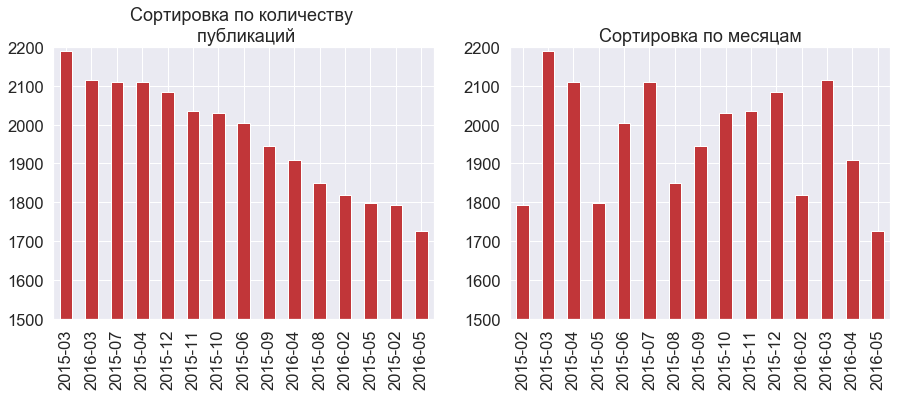

In [169]:
df['y-m'] = df['year'].astype(str) + '-' + df['month']
plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 2, 1)
df['y-m'].value_counts().head(15).plot(kind='bar', title='Сортировка по количеству \n публикаций').set_ylim(1500, 2200)
plt.grid()

plt.subplot(1, 2, 2)
df['y-m'].value_counts().head(15).sort_index().plot(kind='bar', title='Сортировка по месяцам').set_ylim(1500, 2200)
plt.grid()

## 2. Проанализируйте публикации в месяце из предыдущего вопроса

Выберите один или несколько вариантов:

* Один или несколько дней сильно выделяются из общей картины
* На хабре всегда больше статей, чем на гиктаймсе
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр hue; не заморачивайтесь сильно с ответами и не ищите скрытого смысла :)

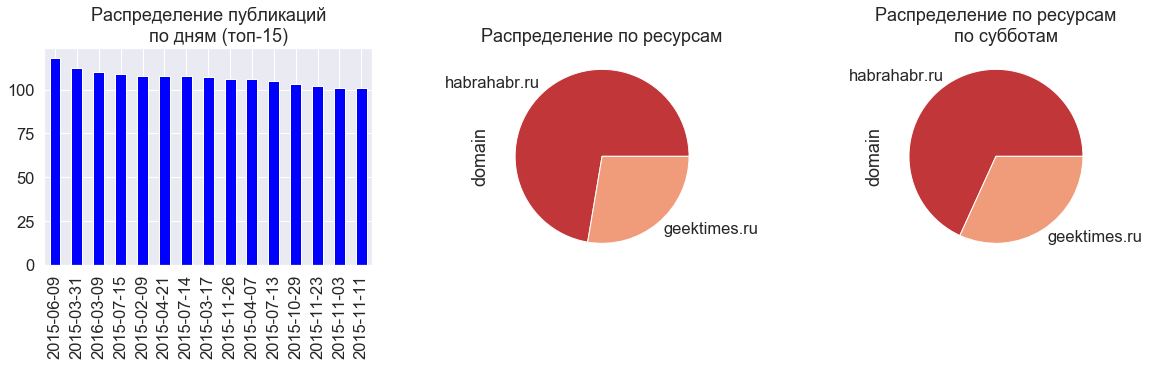

In [170]:
plt.rcParams['figure.figsize'] = [20, 4]

plt.subplot(1, 3, 1)
df['day'] = [str(d)[:10] for d in df.published]
df['day'].value_counts().head(15).plot(kind='bar', color = 'blue', title='''Распределение публикаций
    по дням (топ-15)''')
plt.grid()

plt.subplot(1, 3, 2)
df['domain'].value_counts().plot(kind='pie', title='Распределение по ресурсам')
plt.grid()

plt.subplot(1, 3, 3)
df[df['dayofweek'] == 6]['domain'].value_counts().plot(kind='pie', title='''Распределение по ресурсам
    по субботам''')
plt.grid()

## 3. Когда лучше всего публиковать статью?

* Больше всего просмотров набирают статьи, опубликованные в 12 часов дня
* У опубликованных в 10 утра постов больше всего комментариев
* Больше всего просмотров набирают статьи, опубликованные в 6 часов утра
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера
* На хабре дневные статьи комментируют чаще, чем вечерние

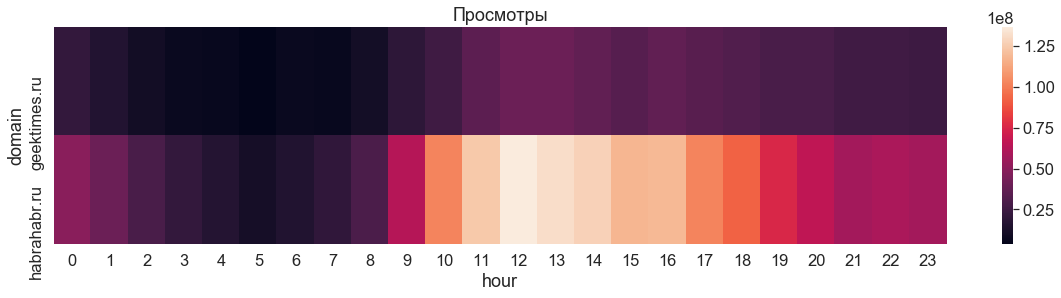

In [171]:
domain_hour_views = df.pivot_table(
    index='domain', 
    columns='hour', 
    values='views', 
    aggfunc=sum
).fillna(0).applymap(float)
ax = plt.axes()
sns.heatmap(domain_hour_views)
ax.set_title('Просмотры')
plt.show()

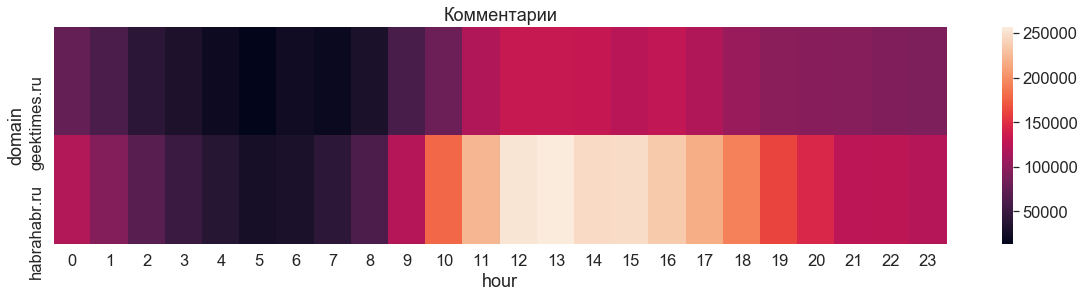

In [172]:
domain_hour_comments = df.pivot_table(
    index='domain', 
    columns='hour', 
    values='comments', 
    aggfunc=sum
).fillna(0).applymap(float)
ax = plt.axes()
sns.heatmap(domain_hour_comments)
ax.set_title('Комментарии')
plt.show()

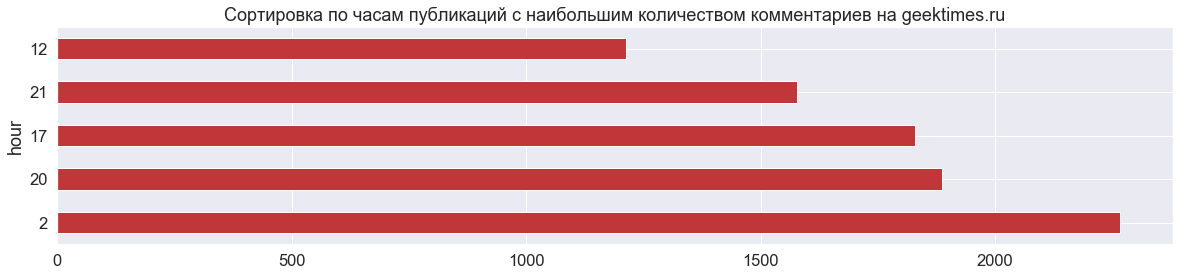

In [173]:
df[df['domain'] == 'geektimes.ru'].set_index('hour')['comments'].sort_values(ascending=False).head().plot(kind='barh', title='Сортировка по часам публикаций с наибольшим количеством комментариев на geektimes.ru')
plt.grid()

## 4. Кого из топ-20 авторов чаще всего минусуют?¶

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

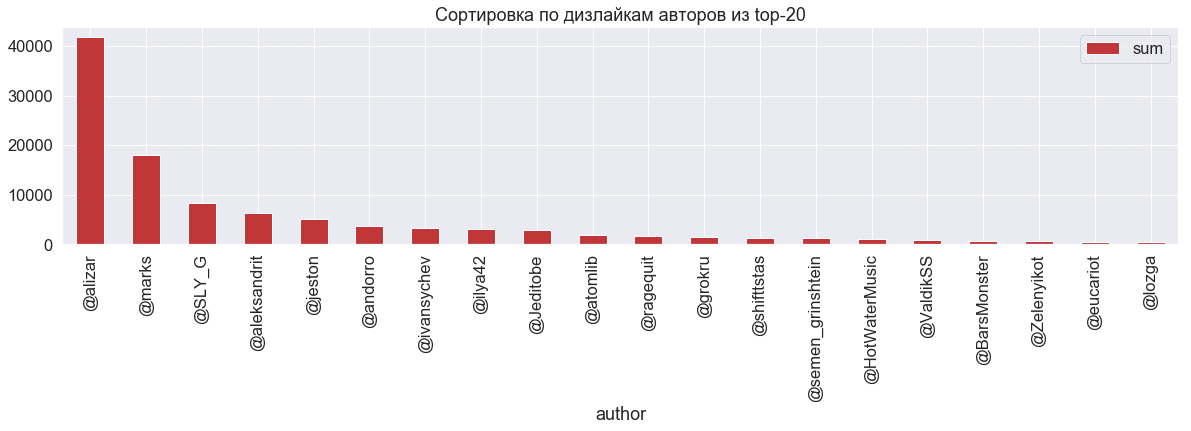

In [215]:
top20 = df.groupby('author')['views'].agg(['sum']).sort_values(by='sum', ascending=False).head(20)
df[df['author'].isin(top20.index)].groupby('author')['votes_minus'].agg(['sum']).sort_values(by='sum', ascending=False).head(20).plot(kind='bar', title='Сортировка по дизлайкам авторов из top-20')
plt.grid()

## 5. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

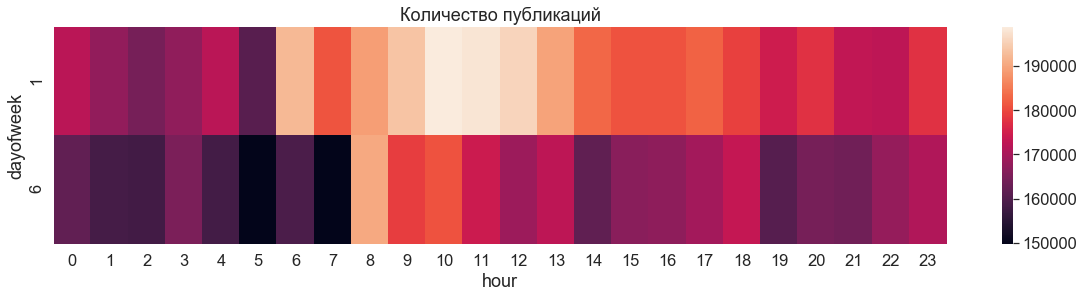

In [214]:
dayofweek_hour_published = df[df['dayofweek'].isin([1,6])].pivot_table(
    index='dayofweek', 
    columns='hour', 
    values='post_id', 
).fillna(0).applymap(float)
ax = plt.axes()
sns.heatmap(dayofweek_hour_published)
ax.set_title('Количество публикаций')
plt.show()